In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math

#####

import json
import bisect
import itertools

import ephem
import datetime

import pprint
pp = pprint.PrettyPrinter(indent=4)

from operator import attrgetter

from tvgutil import contact_plan as cp, tvg

with open("../cache.out/diss_eval/jan_2020_7-28.02.scenario.json", "r") as f:
    scenario = json.load(f)
      
gs_list = scenario["gslist"]
sat_list = scenario["satlist"]

with open("../cache.out/diss_eval/jan_2020_7-28.02.ftvg.json", "r") as f:
    ftvg = tvg.from_serializable(json.load(f))
    
fcp = tvg.to_contact_plan(ftvg)

print(f"Loaded scenario: {len(gs_list)} gs, {len(sat_list)} sat")
print(f"FCP has len = {len(fcp)}")
print(f"F-TVG has {len(ftvg.vertices)} vertices and {len(ftvg.edges)} edges")

from predictutil import SatelliteTrajectoryPredictor

trajectory_predictors = {
        frozenset((gs["id"], sat["id"])): SatelliteTrajectoryPredictor(
            sat["id"],
            sat["tle_list"],
            gs["lat"],
            gs["lon"],
            gs["alt"],
        )
        for gs, sat in itertools.product(gs_list, sat_list)
}

Loaded scenario: 6 gs, 3 sat
FCP has len = 1282
F-TVG has 9 vertices and 36 edges


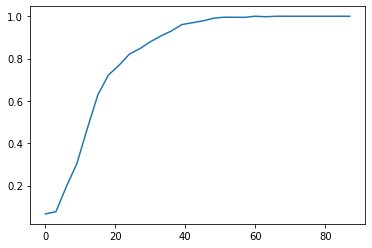

In [2]:
def get_decodability_histogram(fcp_cur, elevation_granularity=3, ber_threshold=1e-6, az_filter=None):
    elevation_range = list(range(0, 90, elevation_granularity))
    ber_bucks = np.array([0. for _ in elevation_range])
    all_bucks = np.array([0. for _ in elevation_range])
    for fc in fcp_cur:
        tp = trajectory_predictors[frozenset((fc.tx_node, fc.rx_node))]
        for i, char in enumerate(fc.characteristics):
            char_start = max(fc.start_time, char.starting_at)
            char_end = fc.characteristics[i + 1].starting_at if i + 1 < len(fc.characteristics) else fc.end_time
            if char_end <= char_start:
                continue
            char_mean = 0.5 * (char_start + char_end)
            char_duration_sec = char_end - char_start
            elev = tp.predict_elevation(char_mean) / math.pi * 180
            if az_filter:
                az = tp.predict_azimuth(char_mean) / math.pi * 180
                if az < az_filter[0] or az >= az_filter[1]:
                    continue
            if char.bit_error_rate <= ber_threshold:
                ber_bucks[int(elev / elevation_granularity)] += char_duration_sec
            all_bucks[int(elev / elevation_granularity)] += char_duration_sec
    return elevation_range, ber_bucks, all_bucks

# Ratio that can be successfully decoded -- over all
elev, ber_bucks, all_bucks = get_decodability_histogram(fcp)
plt.plot(elev, ber_bucks / all_bucks)

<ipython-input-3-f540c65a03ea>:14: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(elev, ber_bucks / all_bucks, label=gs["id"])
<ipython-input-3-f540c65a03ea>:16: RuntimeWarning: invalid value encountered in true_divide
  res = scipy.optimize.curve_fit(fit_fun, elev, ber_bucks / all_bucks)


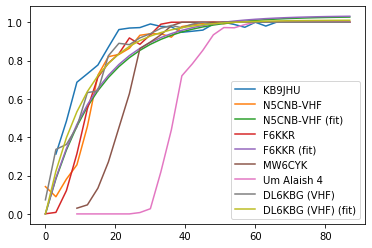

In [3]:
# overall GS quality evaluation

# NOTE: function seems to be roughly: a * (1 - exp(-b * x))
# ...with the asymptote a in [0; 1] and the scaling/rise factor b > 0

import scipy.optimize

def fit_fun(e, a, b):
    return a * (1 - np.exp(-b * e))

for gs in gs_list:
    p = ftvg.edges[(gs["id"], "NOAA 15")] + ftvg.edges[(gs["id"], "NOAA 18")] + ftvg.edges[(gs["id"], "NOAA 19")]
    elev, ber_bucks, all_bucks = get_decodability_histogram(p)
    plt.plot(elev, ber_bucks / all_bucks, label=gs["id"])
    try:
        res = scipy.optimize.curve_fit(fit_fun, elev, ber_bucks / all_bucks)
        plt.plot(elev, [fit_fun(e, res[0][0], res[0][1]) for e in elev], label=(gs["id"] + " (fit)"))
    except ValueError:
        pass
plt.legend()

In [5]:
# This tests the accuracy of get_fc_volume by doing a Monte-Carlo simulation.
# Result: very good

import random
from predictutil import get_fc_volume

# TODO: use CCSDS BLOCK SIZE
BLOCK_SZ = 1500 * 8

def fc_volume_monte_carlo(fc, size, iterations):
    block_count = 0
    for i in range(iterations):
        time = fc.start_time
        while time < fc.end_time:
            cur_char = fc.get_characteristics_at(time)
            p_block_successfully_transmitted = (
                (1 - cur_char.bit_error_rate) ** size
            )
            tx_duration = size / cur_char.bit_rate
            if time + tx_duration > fc.end_time:
                break
            if random.random() < p_block_successfully_transmitted:
                block_count += 1
            time += tx_duration
    return (block_count / iterations) * size

for _ in range(10):
    cur_fc = random.choice(fcp)
    estv = get_fc_volume(cur_fc, BLOCK_SZ)
    simv = fc_volume_monte_carlo(cur_fc, BLOCK_SZ, 20)
    print(round((estv - simv) / estv, 6))

0.068847
0.000215
-8.4e-05
-1.2e-05
0.000123
0.000207
-0.000173
-2.6e-05
-0.000223
0.000187


In [6]:
from predictutil import get_contact, predict_rr0_for_scenario, get_fc_volume

from tvgutil import contact_plan

scenario_start = min(fcp, key=attrgetter("start_time")).start_time
scenario_end = max(fcp, key=attrgetter("end_time")).end_time

rr0_contacts = predict_rr0_for_scenario(
    gs_list,
    sat_list,
    scenario_start,
    scenario_end,
    0,  # NOTE: minelev for PCP is 0 because we modify the predictions!
)
rr0_contacts = [
    (gs, sat, start, end)
    for gs, sat, start, end in rr0_contacts
    if get_contact(ftvg.edges.get((gs, sat), []), start, end)
]
# WARNING: uplink_rate is from first entry of tuple to second (GS -> Sat)
pcp = contact_plan.contact_tuples_to_pcp(
    rr0_contacts,
    0.0,
    uplink_rate=scenario["bit_rate_uplink"],
    downlink_rate=scenario["bit_rate_downlink"],
)
ptvg = tvg.from_contact_plan(pcp)

In [7]:
C_COUNT = 30
PAIRS = [
    ("NOAA 18", "Um Alaish 4"),
    #("NOAA 15", "Um Alaish 4"),
    ("NOAA 15", "N5CNB-VHF"),
    ("NOAA 15", "F6KKR"),
    #("NOAA 19", "F6KKR"),
    ("NOAA 15", "MW6CYK"),
    #("NOAA 19", "MW6CYK"),
    #("NOAA 15", "KB9JHU"),
    ("NOAA 19", "KB9JHU"),
]
# TLE are recorded with the time of the FC for which they were first used
# we thus retrieve TLE from "the future" which are actually much closer to the TLE used for predicting the contact
PREDICT_OFFSET_TIME = 86400
LL_BLOCK_SZ = 1500 * 8
UPDATE_WEIGHT = .4
UPDATE_WEIGHT_E = .4
UPDATE_WEIGHT_Q = .5
WND_SZ = 5

from predictutil import volume

def _get_p_ud(char, start_time, end_time):
    value = 0.0
    for i, c in enumerate(char):
        # The first characteristics entry might be valid earlier than the
        # contact starts. This ensures we only take into account the
        # contact time frame itself.
        char_start = max(
           start_time,
           c[0],
        )
        try:
            char_end = min(
                end_time,
                char[i + 1][0],
            )
        except IndexError:
            # The end of the last entry is the contact end time.
            char_end = end_time
        if char_end <= char_start:
            continue
        value += (char_end - char_start) * c[1]
        if char_end == end_time:
            break
    return value

In [8]:
# MIN ELEV TEST WITH VOLUME

result = {}
plt.axhline(y=0, color="#909090")
for txn, rxn in PAIRS:
    e_fcp = ftvg.edges[(txn, rxn)]
    tp = trajectory_predictors[frozenset([txn, rxn])]
    pred = volume.MinElevationVolumePredictor(tp, min_elevation=10)
    result[(txn, rxn)] = []
    for fc_i, cur_fc in enumerate(e_fcp[0:C_COUNT]):
        rate = cur_fc.to_simple().bit_rate
        cur_pc = get_contact(ptvg.edges[(txn, rxn)], cur_fc.start_time, cur_fc.end_time)
        # usable duration
        vol_fact = get_fc_volume(cur_fc, LL_BLOCK_SZ)
        drf = pred.predict_data_rate_factors(cur_fc.start_time + PREDICT_OFFSET_TIME, cur_pc.start_time, cur_pc.end_time)
        ud_pred = _get_p_ud(drf, cur_pc.start_time, cur_pc.end_time)
        vol_pred = ud_pred * rate
        result[(txn, rxn)].append(vol_pred - vol_fact)
    plt.plot(list(range(len(result[(txn, rxn)]))), result[(txn, rxn)], label=f"{txn} -> {rxn}")
plt.legend()

MEG = 8000000
for pair, r in result.items():
    print(pair, np.mean(r) / MEG, np.std(r) / MEG)
rr = [x for _, r in result.items() for x in r]
print(f"ALL: {np.mean(rr) / MEG}, std = {np.std(rr) / MEG}")

('NOAA 18', 'Um Alaish 4') 43.11971750258659 4.810909887067651
('NOAA 15', 'N5CNB-VHF') 10.579867844914954 9.758153037053805
('NOAA 15', 'F6KKR') 9.214110709935278 9.373524663290175
('NOAA 15', 'MW6CYK') 24.729983679411163 4.103446610006665
('NOAA 19', 'KB9JHU') 1.8538141053237482 8.175464449111395
ALL: 15.952756059160295, std = 15.12870107025593


-> Contact #5 (NOAA 18 -> Um Alaish 4) at 1578589693.0: delta = 22.513, usable = 11.1857, predicted = 33.6987
-> Contact #6 (NOAA 18 -> Um Alaish 4) at 1579069101.0: delta = -7.2438, usable = 33.2441, predicted = 26.0004
-> Contact #15 (NOAA 18 -> Um Alaish 4) at 1580017773.0: delta = -7.8335, usable = 33.3528, predicted = 25.5193
-> Contact #9 (NOAA 15 -> N5CNB-VHF) at 1578581133.0: delta = 24.6762, usable = 33.9168, predicted = 58.593
-> Contact #12 (NOAA 15 -> N5CNB-VHF) at 1578660056.0: delta = -27.0175, usable = 40.3184, predicted = 13.3009
-> Contact #14 (NOAA 15 -> N5CNB-VHF) at 1578700542.0: delta = 14.3877, usable = 6.7228, predicted = 21.1105
-> Contact #17 (NOAA 15 -> N5CNB-VHF) at 1578791328.0: delta = 19.6874, usable = 44.2262, predicted = 63.9136
-> Contact #18 (NOAA 15 -> N5CNB-VHF) at 1578841839.0: delta = 22.5333, usable = 18.6245, predicted = 41.1578
-> Contact #20 (NOAA 15 -> N5CNB-VHF) at 1578926699.0: delta = 26.1312, usable = 35.6804, predicted = 61.8115
-> Contac

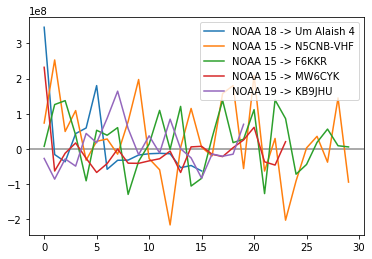

In [9]:
# TriStateVolumePredictor

result = {}
plt.axhline(y=0, color="#909090")
for txn, rxn in PAIRS:
    e_fcp = ftvg.edges[(txn, rxn)]
    tp = trajectory_predictors[frozenset([txn, rxn])]
    pred = volume.TriStateVolumePredictor(
        tp,
        link_block_size=LL_BLOCK_SZ,
        averaging_window_size=WND_SZ,
        #az_granularity=360,
    )
    result[(txn, rxn)] = []
    for fc_i, cur_fc in enumerate(e_fcp[0:C_COUNT]):
        rate = cur_fc.to_simple().bit_rate
        cur_pc = get_contact(ptvg.edges[(txn, rxn)], cur_fc.start_time, cur_fc.end_time)
        # usable duration
        vol_fact = get_fc_volume(cur_fc, LL_BLOCK_SZ)
        drf = pred.predict_data_rate_factors(cur_fc.start_time + PREDICT_OFFSET_TIME, cur_pc.start_time, cur_pc.end_time)
        ud_pred = _get_p_ud(drf, cur_pc.start_time, cur_pc.end_time)
        vol_pred = ud_pred * rate
        result[(txn, rxn)].append(vol_pred - vol_fact)
        if fc_i > 4 and (vol_pred / vol_fact < 0.8 or vol_pred / vol_fact > 1.2):
            print(f"-> Contact #{fc_i} ({txn} -> {rxn}) at {cur_fc.start_time}: delta = {round((vol_pred - vol_fact) / MEG, 4)}, usable = {round(vol_fact / MEG, 4)}, predicted = {round(vol_pred / MEG, 4)}")
        pred.observe_contact(cur_fc)
    plt.plot(list(range(len(result[(txn, rxn)]))), result[(txn, rxn)], label=f"{txn} -> {rxn}")
plt.legend()

MEG = 8000000
for pair, r in result.items():
    print(pair, np.mean(r) / MEG, np.std(r) / MEG)
rr = [x for _, r in result.items() for x in r]
print(f"ALL: {np.mean(rr) / MEG}, std = {np.std(rr) / MEG}")

('NOAA 18', 'Um Alaish 4') 2.5889733375516206 11.364497450536238
('NOAA 15', 'N5CNB-VHF') 5.120772703512812 20.729375187393266
('NOAA 15', 'F6KKR') -1.7679135538807889 16.512613887035528
('NOAA 15', 'MW6CYK') 0.18554736984780398 7.485289226036256
('NOAA 19', 'KB9JHU') 1.8747119804086612 7.913157999792137
ALL: 1.5329727031192264, std = 14.863685594534317


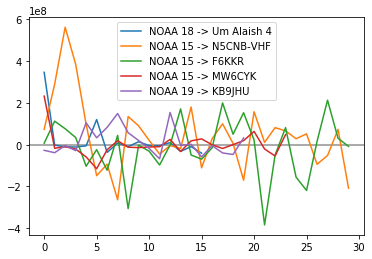

In [10]:
# TwoStateVolumePredictor

result = {}
plt.axhline(y=0, color="#909090")
for txn, rxn in PAIRS:
    e_fcp = ftvg.edges[(txn, rxn)]
    tp = trajectory_predictors[frozenset([txn, rxn])]
    pred = volume.TwoStateVolumePredictor(
        tp,
        link_block_size=LL_BLOCK_SZ,
        averaging_window_size=WND_SZ,
    )
    result[(txn, rxn)] = []
    for fc_i, cur_fc in enumerate(e_fcp[0:C_COUNT]):
        rate = cur_fc.to_simple().bit_rate
        cur_pc = get_contact(ptvg.edges[(txn, rxn)], cur_fc.start_time, cur_fc.end_time)
        vol_fact = get_fc_volume(cur_fc, LL_BLOCK_SZ)
        drf = pred.predict_data_rate_factors(cur_fc.start_time + PREDICT_OFFSET_TIME, cur_pc.start_time, cur_pc.end_time)
        # usable duration
        ud_pred = _get_p_ud(drf, cur_pc.start_time, cur_pc.end_time)
        vol_pred = ud_pred * rate
        result[(txn, rxn)].append(vol_pred - vol_fact)
        pred.observe_contact(cur_fc)
    plt.plot(list(range(len(result[(txn, rxn)]))), result[(txn, rxn)], label=f"{txn} -> {rxn}")
plt.legend()

MEG = 8000000
for pair, r in result.items():
    print(pair, np.mean(r) / MEG, np.std(r) / MEG)
rr = [x for _, r in result.items() for x in r]
# TODO: percentile for difference
print(f"ALL: {np.mean(rr) / MEG}, std = {np.std(rr) / MEG}")

('NOAA 18', 'Um Alaish 4') 3.1038466434705647 14.94063187832095
('NOAA 15', 'N5CNB-VHF') 39.23046968110859 11.421690253007547
('NOAA 15', 'F6KKR') 6.403295385241554 11.041218237635672
('NOAA 15', 'MW6CYK') 5.438017145979147 9.230148966169391
('NOAA 19', 'KB9JHU') 2.482241565499851 8.280035696217313
ALL: 13.32359784249608, std = 18.628877347343998


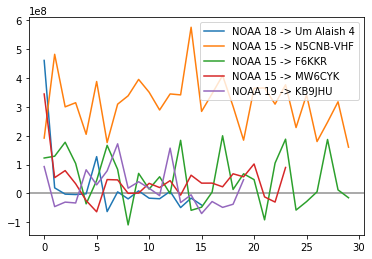

In [11]:
# Xpred

from predictutil.volume import XPredBasedVolumePredictor

result = {}
plt.axhline(y=0, color="#909090")
for txn, rxn in PAIRS:
    e_fcp = ftvg.edges[(txn, rxn)]
    tp = trajectory_predictors[frozenset([txn, rxn])]
    pred = XPredBasedVolumePredictor(
        tp,
    )
    result[(txn, rxn)] = []
    for fc_i, cur_fc in enumerate(e_fcp[0:C_COUNT]):
        rate = cur_fc.to_simple().bit_rate
        cur_pc = get_contact(ptvg.edges[(txn, rxn)], cur_fc.start_time, cur_fc.end_time)
        # usable duration
        vol_fact = get_fc_volume(cur_fc, LL_BLOCK_SZ)
        drf = pred.predict_data_rate_factors(cur_fc.start_time + PREDICT_OFFSET_TIME, cur_pc.start_time, cur_pc.end_time)
        ud_pred = _get_p_ud(drf, cur_pc.start_time, cur_pc.end_time)
        vol_pred = ud_pred * rate
        result[(txn, rxn)].append(vol_pred - vol_fact)
        pred.observe_contact(cur_fc)
    plt.plot(list(range(len(result[(txn, rxn)]))), result[(txn, rxn)], label=f"{txn} -> {rxn}")
plt.legend()

MEG = 8000000
for pair, r in result.items():
    print(pair, np.mean(r) / MEG, np.std(r) / MEG)
rr = [x for _, r in result.items() for x in r]
print(f"ALL: {np.mean(rr) / MEG}, std = {np.std(rr) / MEG}")

In [13]:
with open("../cache.out/dl4fw/dl4fw.02.scenario.json", "r") as f:
    dl4fw_scenario = json.load(f)
      
dl4fw_gs_list = dl4fw_scenario["gslist"]
dl4fw_sat_list = dl4fw_scenario["satlist"]

with open("../cache.out/dl4fw/dl4fw.02.ftvg.json", "r") as f:
    dl4fw_ftvg = tvg.from_serializable(json.load(f))
    
dl4fw_fcp = tvg.to_contact_plan(dl4fw_ftvg)

print(f"Loaded scenario: {len(dl4fw_gs_list)} gs, {len(dl4fw_sat_list)} sat")
print(f"FCP has len = {len(dl4fw_fcp)}")
print(f"F-TVG has {len(dl4fw_ftvg.vertices)} vertices and {len(dl4fw_ftvg.edges)} edges")

dl4fw_trajectory_predictors = {
        frozenset((gs["id"], sat["id"])): SatelliteTrajectoryPredictor(
            sat["id"],
            sat["tle_list"],
            gs["lat"],
            gs["lon"],
            gs["alt"],
        )
        for gs, sat in itertools.product(dl4fw_gs_list, dl4fw_sat_list)
}

dl4fw_scenario_start = min(dl4fw_fcp, key=attrgetter("start_time")).start_time
dl4fw_scenario_end = max(dl4fw_fcp, key=attrgetter("end_time")).end_time

dl4fw_rr0_contacts = predict_rr0_for_scenario(
    dl4fw_gs_list,
    dl4fw_sat_list,
    dl4fw_scenario_start,
    dl4fw_scenario_end,
    0,  # NOTE: minelev for PCP is 0 because we modify the predictions!
)
dl4fw_rr0_contacts = [
    (gs, sat, start, end)
    for gs, sat, start, end in dl4fw_rr0_contacts
    if get_contact(dl4fw_ftvg.edges.get((gs, sat), []), start, end)
]
# WARNING: uplink_rate is from first entry of tuple to second (GS -> Sat)
dl4fw_pcp = contact_plan.contact_tuples_to_pcp(
    dl4fw_rr0_contacts,
    0.0,
    uplink_rate=dl4fw_scenario["bit_rate_uplink"],
    downlink_rate=dl4fw_scenario["bit_rate_downlink"],
)
dl4fw_ptvg = tvg.from_contact_plan(dl4fw_pcp)

C_COUNT = 20
DL4FW_NAME = "DL4FW - Burkau Test Station"
PAIRS = [
    ("NOAA 15", DL4FW_NAME),
    ("NOAA 18", DL4FW_NAME),
    ("NOAA 19", DL4FW_NAME),
]
# TLE are recorded with the time of the FC for which they were first used
# we thus retrieve TLE from "the future" which are actually much closer to the TLE used for predicting the contact
PREDICT_OFFSET_TIME = 86400
LL_BLOCK_SZ = 1500 * 8

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 24))

result = {}
ax1.axhline(y=0, color="#909090")
for txn, rxn in PAIRS:
    e_fcp = dl4fw_ftvg.edges[(txn, rxn)]
    tp = dl4fw_trajectory_predictors[frozenset([txn, rxn])]
    pred = volume.TwoStateVolumePredictor(
        tp,
        link_block_size=LL_BLOCK_SZ,
        averaging_window_size=WND_SZ,
    )
    result[(txn, rxn)] = []
    for fc_i, cur_fc in enumerate(e_fcp[0:C_COUNT]):
        rate = cur_fc.to_simple().bit_rate
        cur_pc = get_contact(dl4fw_ptvg.edges[(txn, rxn)], cur_fc.start_time, cur_fc.end_time)
        if not cur_pc:
            continue
        vol_fact = get_fc_volume(cur_fc, LL_BLOCK_SZ)
        drf = pred.predict_data_rate_factors(cur_fc.start_time + PREDICT_OFFSET_TIME, cur_pc.start_time, cur_pc.end_time)
        # usable duration
        ud_pred = _get_p_ud(drf, cur_pc.start_time, cur_pc.end_time)
        vol_pred = ud_pred * rate
        result[(txn, rxn)].append(vol_pred - vol_fact)
        pred.observe_contact(cur_fc)
    ax1.plot(list(range(len(result[(txn, rxn)]))), result[(txn, rxn)], label=f"{txn} -> {rxn}")
ax1.legend()

result = {}
ax2.axhline(y=0, color="#909090")
for txn, rxn in PAIRS:
    e_fcp = dl4fw_ftvg.edges[(txn, rxn)]
    tp = dl4fw_trajectory_predictors[frozenset([txn, rxn])]
    pred = volume.TriStateVolumePredictor(
        tp,
        link_block_size=LL_BLOCK_SZ,
        averaging_window_size=WND_SZ,
    )
    result[(txn, rxn)] = []
    for fc_i, cur_fc in enumerate(e_fcp[0:C_COUNT]):
        rate = cur_fc.to_simple().bit_rate
        cur_pc = get_contact(dl4fw_ptvg.edges[(txn, rxn)], cur_fc.start_time, cur_fc.end_time)
        if not cur_pc:
            continue
        vol_fact = get_fc_volume(cur_fc, LL_BLOCK_SZ)
        drf = pred.predict_data_rate_factors(cur_fc.start_time + PREDICT_OFFSET_TIME, cur_pc.start_time, cur_pc.end_time)
        # usable duration
        ud_pred = _get_p_ud(drf, cur_pc.start_time, cur_pc.end_time)
        vol_pred = ud_pred * rate
        result[(txn, rxn)].append(vol_pred - vol_fact)
        pred.observe_contact(cur_fc)
    ax2.plot(list(range(len(result[(txn, rxn)]))), result[(txn, rxn)], label=f"{txn} -> {rxn}")
ax2.legend()

result = {}
ax3.axhline(y=0, color="#909090")
for txn, rxn in PAIRS:
    e_fcp = dl4fw_ftvg.edges[(txn, rxn)]
    tp = dl4fw_trajectory_predictors[frozenset([txn, rxn])]
    pred = volume.MinElevationVolumePredictor(
        tp,
        min_elevation=10,
    )
    result[(txn, rxn)] = []
    for fc_i, cur_fc in enumerate(e_fcp[0:C_COUNT]):
        rate = cur_fc.to_simple().bit_rate
        cur_pc = get_contact(dl4fw_ptvg.edges[(txn, rxn)], cur_fc.start_time, cur_fc.end_time)
        if not cur_pc:
            continue
        vol_fact = get_fc_volume(cur_fc, LL_BLOCK_SZ)
        drf = pred.predict_data_rate_factors(cur_fc.start_time + PREDICT_OFFSET_TIME, cur_pc.start_time, cur_pc.end_time)
        # usable duration
        ud_pred = _get_p_ud(drf, cur_pc.start_time, cur_pc.end_time)
        vol_pred = ud_pred * rate
        result[(txn, rxn)].append(vol_pred - vol_fact)
        pred.observe_contact(cur_fc)
    ax3.plot(list(range(len(result[(txn, rxn)]))), result[(txn, rxn)], label=f"{txn} -> {rxn}")
ax3.legend()

Loaded scenario: 1 gs, 3 sat
FCP has len = 82
F-TVG has 4 vertices and 6 edges
